<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_5_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Neural Style Transfer**

Neural Style Transfer is a technique often used in Data Augmentation that consist in the application of the style of certain reference image to a base image, while maintining the content of the original.

**Figure 1:  Style Transfer**
![Style Transfer](https://godatadriven.com/wp-content/images/how-to-style-transfer/style-transfer-example.jpg)

In [2]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


### Upload **Content** Image

In [1]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    base_image_path = f"source{ext}"
    open(base_image_path, 'wb').write(v)

Saving seal.jpg to seal.jpg


### Upload **Style** Image

In [5]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    style_reference_image_path = f"style{ext}"
    open(style_reference_image_path, 'wb').write(v)

Saving monet.png to monet.png


In [6]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Importing neural network model VGG19
from tensorflow.keras.applications import vgg19

result_prefix = "generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Setting the dimensions of the new generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## Images Display

Source Image


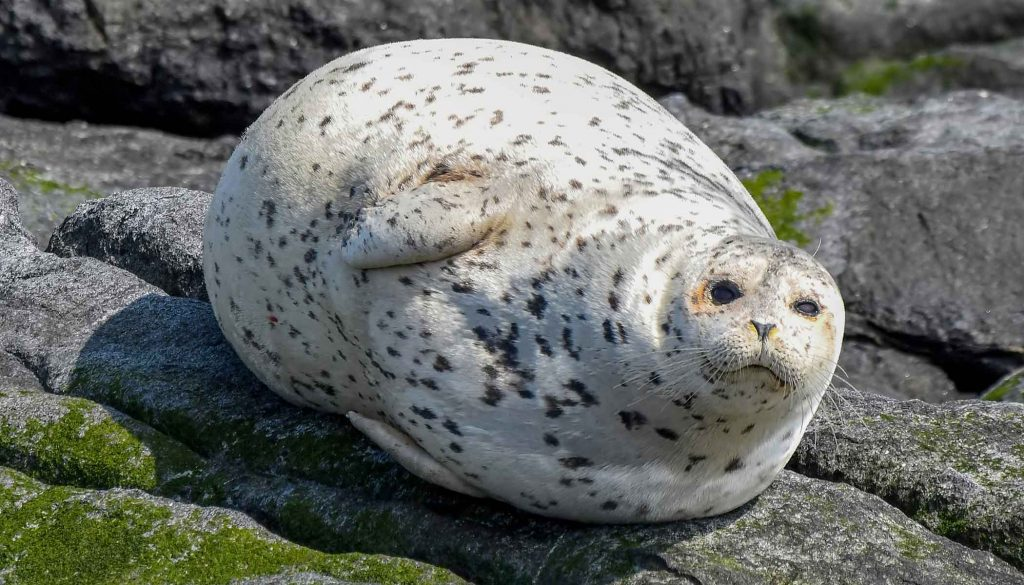

In [7]:
from IPython.display import Image, display

print("Source Image")
display(Image(base_image_path))

In [8]:
print("Style Image")
display(Image(style_reference_image_path))

Output hidden; open in https://colab.research.google.com to view.

## Image Preprocessing and Postprocessing


In [9]:
def preprocess_image(image_path):
    # Image loading and scaling
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))

    # Normalize the pixel values
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Conversion from 'BGR' to 'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Needed Calculations the Loss Components

**Figure 2: The Gram Matrix**
![The Gram Matrix](https://data.heatonresearch.com/images/jupyter/gram.jpg)



* **Style Loss** - Difference between the **generated** image and **style** image
* **Content Loss** - Difference in content between the **generated** image and the **original** one.
* **Total Variation Loss** - Difference between **pixel values**

In [10]:
# The gram matrix of an image tensor
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# Style Loss Function
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) /\
      (4.0 * (channels ** 2) * (size ** 2))


# Content Loss Function
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# Total Variation Loss Function
def total_variation_loss(x):
    # Difference between pixels along the height of the image
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] \
          - x[:, 1:, : img_ncols - 1, :]
    )
    # Difference between pixels along the width of the image
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] \
          - x[:, : img_nrows - 1, 1:, :]
    )
    # Computing the total loss
    return tf.reduce_sum(tf.pow(a + b, 1.25))


## Setting up the VGG Neural Network



In [11]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each layer.
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in VGG19
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    # Prepare for processing
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * \
      total_variation_loss(combination_image)
    return loss

## Generating the Style Transferred Image


In [13]:
@tf.function
def compute_loss_and_grads(combination_image, \
                  base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, \
                base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

We can now optimize the image according to the loss function.

In [14]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 3000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=1922.99
Iteration 200: loss=1260.42
Iteration 300: loss=1022.07
Iteration 400: loss=901.02
Iteration 500: loss=827.30
Iteration 600: loss=777.48
Iteration 700: loss=741.30
Iteration 800: loss=713.74
Iteration 900: loss=691.88
Iteration 1000: loss=674.13
Iteration 1100: loss=659.40
Iteration 1200: loss=646.97
Iteration 1300: loss=636.32
Iteration 1400: loss=627.12
Iteration 1500: loss=619.08
Iteration 1600: loss=612.00
Iteration 1700: loss=605.72
Iteration 1800: loss=600.11
Iteration 1900: loss=595.06
Iteration 2000: loss=590.50
Iteration 2100: loss=586.35
Iteration 2200: loss=582.58
Iteration 2300: loss=579.13
Iteration 2400: loss=575.97
Iteration 2500: loss=573.06
Iteration 2600: loss=570.38
Iteration 2700: loss=567.90
Iteration 2800: loss=565.60
Iteration 2900: loss=563.46
Iteration 3000: loss=561.47


We can display the image.

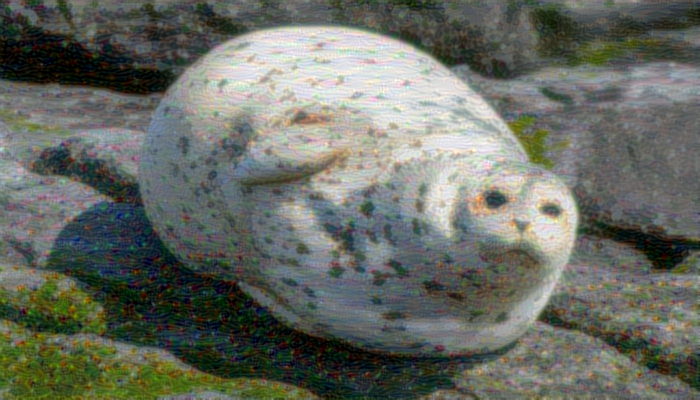

In [17]:
display(Image(result_prefix + "_at_iteration_3000.png"))